In [1]:
import xarray as xr
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
zarr_array = xr.open_zarr('SW_04_SWP_01.zarr')

depth_data = zarr_array['depth'][::7].values
date_data = zarr_array['time'][::7].values
zarr_array.close()
template_map = np.array([len(depth[~np.isnan(depth)]) for depth in depth_data]).argmax()
original_shape = depth_data[template_map].shape


mask = np.isnan(depth_data[template_map])
mask
averaged_depth = np.nanmean(depth_data, axis=(0))


C:\Users\jbroders\AppData\Local\Temp\ipykernel_20940\3581549271.py:12: RuntimeWarning: Mean of empty slice
  averaged_depth = np.nanmean(depth_data, axis=(0))


In [3]:
def random_masking(depths,mask,scale=1):
    random_mask = deepcopy(depths)
    for array in depths:
        array[mask] = np.random.random(size=np.sum(mask))*scale
        array[array==None] = 0
        array[array==np.nan] = 0
    return random_mask      
        
        

In [4]:

#def replace_non_common_nans(mask:np.ndarray,array:np.ndarray):
 #       nan_mask = np.isnan(array)
  #      array[~mask & nan_mask] = 0
   #     return array

#def test_nans(test:np.ndarray,control:np.ndarray):
 #       if len(test[~np.isnan(test)]) != len(control[~np.isnan(control)]):
  #              print("Dimensions wrong")


In [5]:
weeks_in=8
weeks_out=4

In [6]:
1323/2

661.5

In [7]:
782/2

391.0

In [8]:
def downscale_array_avg(array, factor):
    reshaped_array = array.reshape((array.shape[0] // factor, factor, array.shape[1] // factor, factor))
    downscaled_array = reshaped_array.mean(axis=(1, 3))
    return downscaled_array

In [9]:
depth_data.shape

(605, 1323, 782)

In [10]:
output_shape = (662, 391)

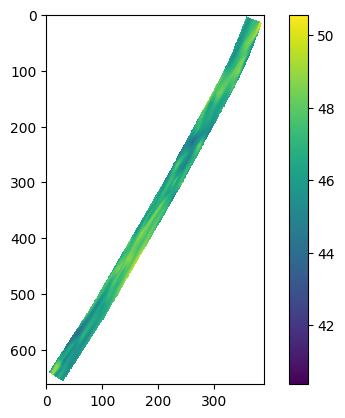

In [11]:
from skimage.transform import resize
reduced_depths = [depth for depth in depth_data if len(depth_data[template_map][~np.isnan(depth_data[template_map])]) == len(depth[~np.isnan(depth)])]
reduced_depths = [resize(depth, output_shape, anti_aliasing=True) for depth in reduced_depths]
plt.imshow(reduced_depths[10])
plt.colorbar()
plt.show()

In [12]:
min([np.nanmin(depth) for depth in depth_data])

30.25678253173828

In [13]:
def dredge_percent_collection(depth,date):
    dredge_percent=[]
    threshold_deepening = 50
    threshold_pre_deepening = 45
    combined= [(pos, time) for pos, time in zip(depth, date)]
    for item in combined:
        if item[1]< np.datetime64('2020-01-01'):
            dredge = (item[0]< threshold_pre_deepening).sum()/(~np.isnan(item[0])).sum()
            dredge_percent.append([dredge,item[1]])
        else:
            dredge = (item[0]< threshold_deepening).sum()/(~np.isnan(item[0])).sum()
            dredge_percent.append([dredge,item[1]])
    return dredge_percent

In [14]:
dredge_percent = dredge_percent_collection(depth_data,date_data)

In [15]:
dredge_percent = np.array(dredge_percent,dtype='object')

In [16]:
dredge_percent[0][:]

array([0.2209752706326348,
       numpy.datetime64('2012-01-03T00:00:00.000000000')], dtype=object)

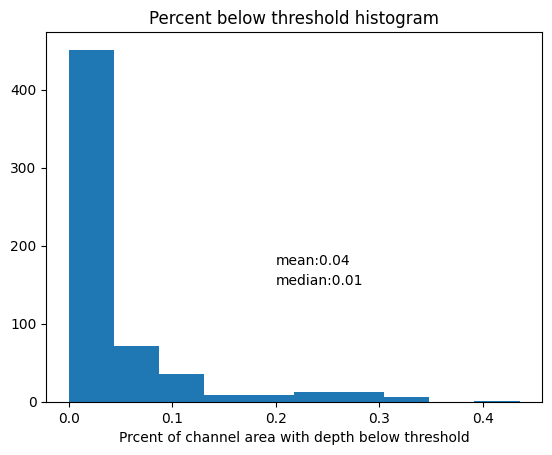

In [17]:
plt.hist(dredge_percent[:,0],bins=10)
plt.xlabel('Prcent of channel area with depth below threshold')
plt.title('Percent below threshold histogram')
plt.text(.2,175,f"mean:{np.mean(dredge_percent[:,0]):.2f}")
plt.text(.2,150,f"median:{np.median(dredge_percent[:,0]):.2f}")
plt.show()

In [18]:
max_depth =80
min_depth = 20
percent_below = dredge_percent[:,0]
scaled_depths = [(arr - min_depth) / (max_depth - min_depth) for arr in reduced_depths]

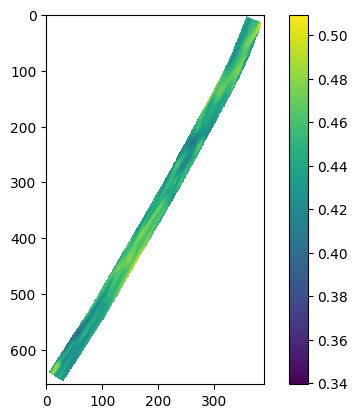

In [19]:
plt.imshow(scaled_depths[10])
plt.colorbar()
plt.show()

In [20]:

reduced_mask = np.isnan(reduced_depths[0])

In [21]:
masked_depths = random_masking(scaled_depths,reduced_mask,0)
masked_depths = random_masking(scaled_depths,reduced_mask,0)

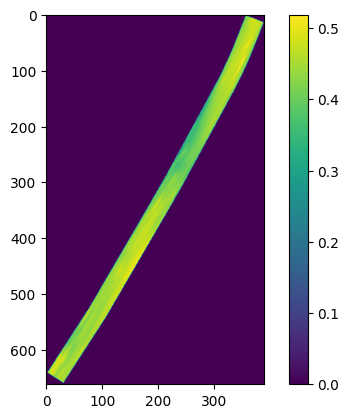

In [22]:
plt.imshow(masked_depths[1])
plt.colorbar()
plt.show()

In [23]:
percent_below

array([0.2209752706326348, 0.25685497341073865, 0.2231240802101861,
       0.24632761220307153, 0.15076878628373316, 0.12547061638331874,
       0.19907185872028457, 0.14887277783295264, 0.1488276347746007,
       0.06613458048555873, 0.08698164483247411, 0.015402811509674158,
       0.06063615597829522, 0.13746061268158796, 0.1107088363022418,
       0.06213490551557887, 0.060536841249921, 0.03411912350237904,
       0.05025325255735426, 0.05102971316100723, 0.05259166297998357,
       0.0484294729999368, 0.05245623380492782, 0.11343547702669761,
       0.10524652624165982, 0.10149965239845068, 0.040348865554943616,
       0.009814100885706806, 0.010626675936041314, 0.003385729376393792,
       0.005994998149134608, 0.0034399010464160927, 0.007927121046596665,
       0.002816926841159635, 0.006004026760804991, 0.0058234545273973225,
       0.009606442817287985, 0.009425870583880317, 0.009218212515461498,
       0.011312850422990456, 0.013678346680630919, 0.010491246760985564,
       0

In [24]:
def create_sequences(data, input_length, output_length,y_predefined= None,date=None):
    X, y = [], []
    for i in range(len(data) - input_length - output_length + 1):
        X.append(data[i:i + input_length])
        if y_predefined.any()== None:
            y.append(np.nanmin(data[i + input_length + output_length-1]))
        else:
            y.append(y_predefined[i+input_length+output_length-1])

    return np.array(X), np.array(y)


sequence_depths_X,sequence_depths_y = create_sequences(masked_depths, weeks_in, weeks_out,dredge_percent)

In [25]:
#train_X = np.moveaxis(train_X, 1, -1)
#test_X = np.moveaxis(test_X, 1, -1)


train_X, test_X, train_y, test_y = train_test_split(sequence_depths_X, sequence_depths_y, test_size=0.2, random_state=42)
print(train_X.shape)

# Print shapes to verify

train_X = np.transpose(train_X,(0,2,3,1))
print(train_X.shape)
test_X = np.transpose(test_X,(0,2,3,1))

train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y[:,0].tolist()))
test_dataset = tf.data.Dataset.from_tensor_slices((test_X, test_y[:,0].tolist()))

train_dataset = train_dataset.batch(64)
test_dataset = test_dataset.batch(64)


(464, 8, 662, 391)
(464, 662, 391, 8)


In [26]:
train_X.shape

(464, 662, 391, 8)

In [27]:
output_shape[0]

662

In [28]:
#Change how layers work
import visualkeras

c:\Users\jbroders\AppData\Local\anaconda3\envs\tf_test\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 659, 388, 16)   │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 164, 97, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 161, 94, 32)    │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 20, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 2, 16)       │        16,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,937 (281.00 KB)

 Trainable params: 71,937 (281.00 KB)

 Non-trainable params: 0 (0.00 B)

c:\Users\jbroders\AppData\Local\anaconda3\envs\tf_test\lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


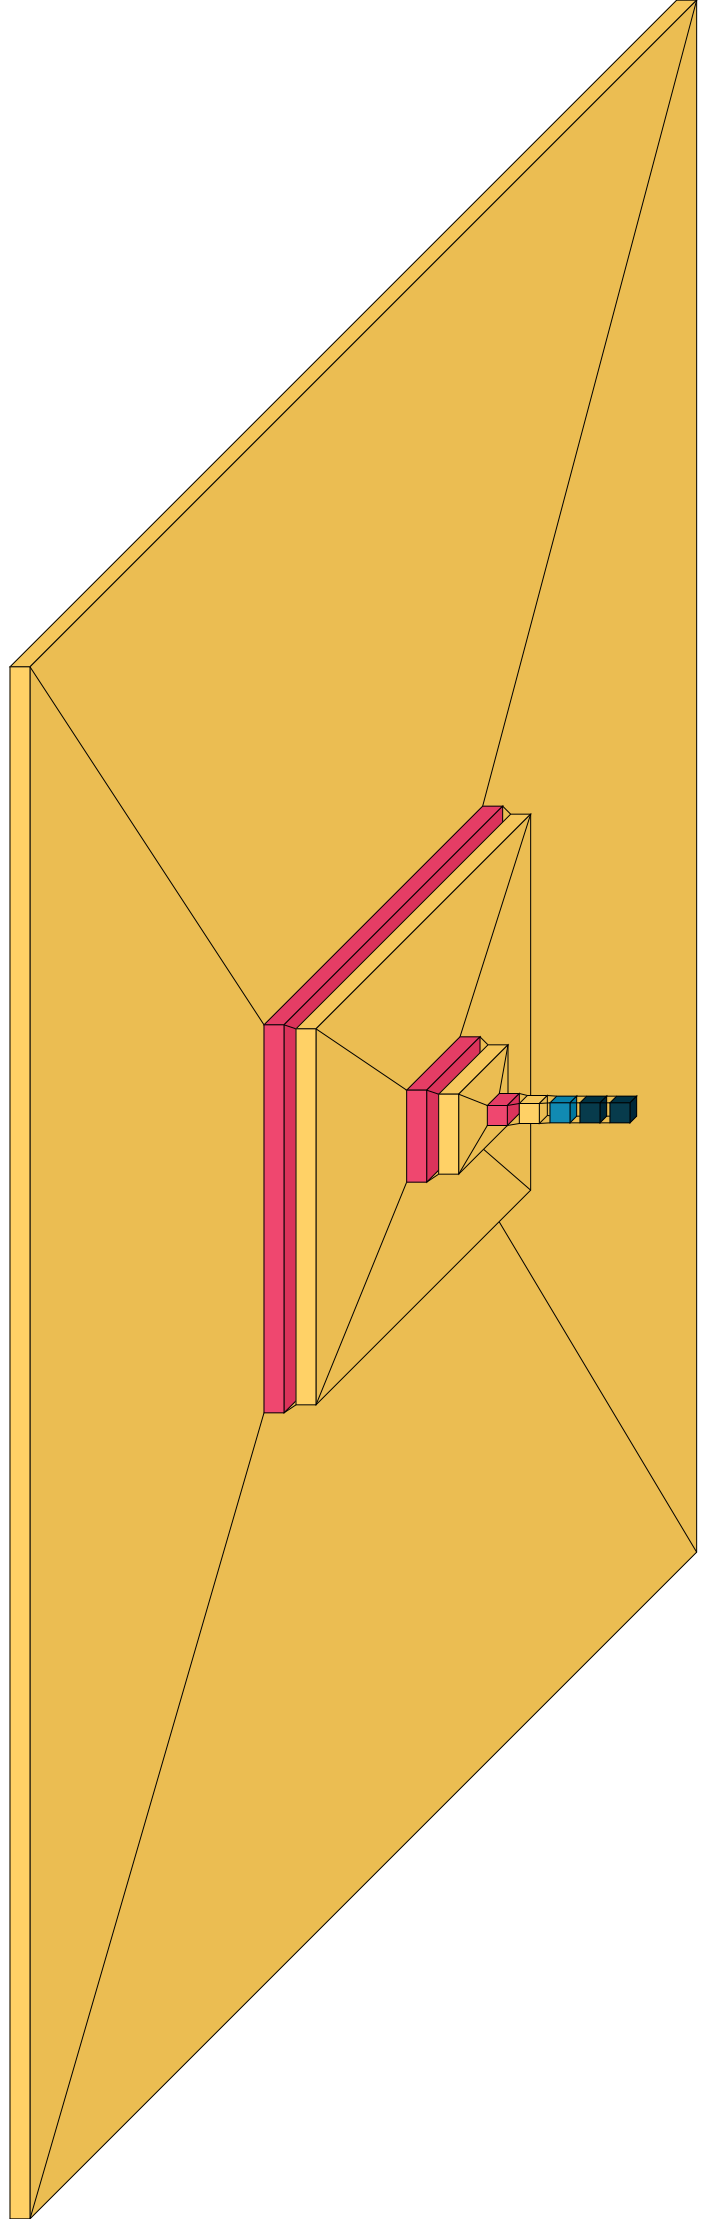

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense, MaxPool3D, Flatten, Input,Dropout,Conv2D,Conv3D, MaxPool2D

# Define your model
model = Sequential()
optimizer= tf.keras.optimizers.Adam(learning_rate=0.0005)

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(4, 4), activation='relu', input_shape=( 662, 391,8)))
model.add(MaxPool2D(pool_size=(4, 4)))
model.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu'))
model.add(MaxPool2D(pool_size=(4, 4)))
model.add(Conv2D(filters=64, kernel_size=(4, 4), activation='relu'))
model.add(MaxPool2D(pool_size=(4, 4)))
model.add(Conv2D(filters=16, kernel_size=(4, 4), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(1))

# Compile your model
model.compile(optimizer=optimizer, loss='mse',metrics = ['mae'])

# Print model summary
model.summary()

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model)

In [30]:
history = model.fit(train_dataset,epochs=300, validation_data=(test_dataset),callbacks=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",patience=15, start_from_epoch=0,restore_best_weights=True))

Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 488ms/step - loss: 0.5715 - mae: 0.7437 - val_loss: 0.0372 - val_mae: 0.1861
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 438ms/step - loss: 0.0443 - mae: 0.1837 - val_loss: 0.0065 - val_mae: 0.0564
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 442ms/step - loss: 0.0156 - mae: 0.1031 - val_loss: 0.0157 - val_mae: 0.1170
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 427ms/step - loss: 0.0102 - mae: 0.0833 - val_loss: 0.0126 - val_mae: 0.0828
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 432ms/step - loss: 0.0115 - mae: 0.0731 - val_loss: 0.0073 - val_mae: 0.0695
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 442ms/step - loss: 0.0077 - mae: 0.0708 - val_loss: 0.0056 - val_mae: 0.0522
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 447ms/step - loss: 0.0069 - mae: 0.0548 - val_loss: 0.0055 - val_mae: 0.0524
Epoch 8/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 434ms/step - loss: 0.0065 - mae: 0.0565 - val_loss: 0.0055 - val_mae: 0.0545
Epoch 9/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 439ms/step - loss: 0.006

In [31]:
pred_y = model.predict(test_X,verbose=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


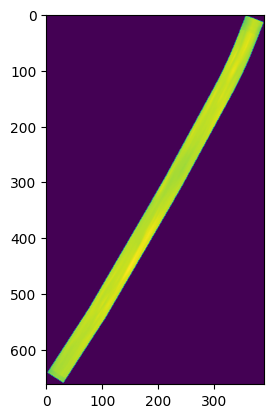

In [32]:
plt.imshow(test_X[0,:,:,0])

In [33]:
import matplotlib.dates as mdates
from datetime import datetime

In [34]:
x = np.arange(len(pred_y[60:70]))  # Create an array of indices for the bars

dates = [pd.Timestamp(d).to_pydatetime() for d in dates_np]

# Convert datetime objects to string in desired format
dates_str = [d.strftime('%Y-%m-%d') for d in dates]

width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, test_y[60:70,0]*100
                ,width, label='Actual (test_y)')
rects2 = ax.bar(x + width/2, pred_y[60:70].flatten()
                *100
                ,width, label='Predicted (pred_y)')

# Add labels, title, and legend
ax.set_xlabel('Date')
ax.set_ylabel('Percent Below Threshold')
ax.set_title('Comparison of Actual vs Predicted')
ax.set_xticks(x)
ax.set_xticklabels(dates_str, rotation=45, ha='right')
ax.legend()

# Optionally, add value labels on top of the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',  # Format to 2 decimal places
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Rotate date labels for better readability
plt.xticks(rotation=45)
plt.ylim(0,30)
fig.tight_layout()

# Rotate date labels for better readability
plt.xticks(rotation=45)
plt.ylim(0,30)

#plt.savefig(f"Images\\Comparison_of_Actual_vs_Predicted_{weeks_in}-{weeks_out}.png")
plt.show()

plt.show()


NameError: name 'dates_np' is not defined

In [35]:
test_y[60:70,0]

array([0.014879152032791918, 0.0, 0.010491246760985564,
       0.024124450383264565, 0.012089311026643432, 0.008161864950026635,
       0.26136025063426, 0.023727191469767695, 0.010328731750918661,
       0.015321554004640706], dtype=object)

In [36]:
rmse = np.sqrt(np.mean((test_y[:,0] - pred_y.flatten()) ** 2))
mae = np.mean(np.abs((test_y[:,0] - pred_y.flatten())))

In [37]:
threshold_date = np.datetime64('2020-01-01')

colors = [
    'green' if test[0] < 0.2 and test[1] < threshold_date else
    'blue' if test[0] < 0.2 and test[1] >= threshold_date else
    'yellow' if test[0] >= 0.2 and test[1] < threshold_date else
    'red'  # test[0] >= 0.2 and test[1] >= threshold_date
    for test in test_y
]

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\jbroders\\Downloads\\SWP_04_05_06\\Images\\Prediction_vs_Actual_Percent_Below_Threshold_8-4.png'

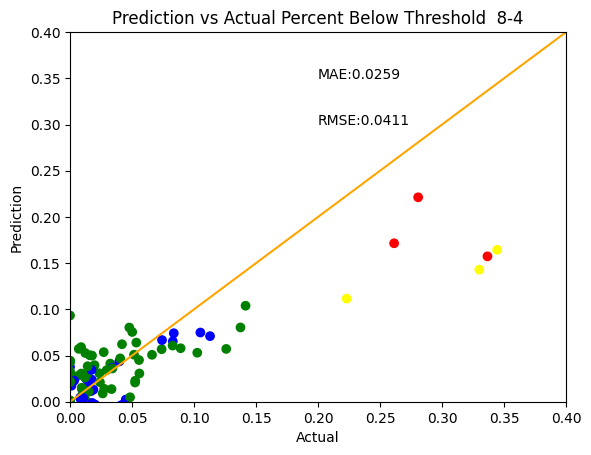

In [38]:

plt.scatter(test_y[:,0],pred_y,c=colors)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.xlim(0,.4)
plt.ylim(0,.4)
plt.plot(np.linspace(-1,1,2),np.linspace(-1,1,2),color='orange')
plt.text(.2,.3,f"RMSE:{rmse:.4f}")
plt.text(.2,.35,f"MAE:{mae:.4f}")
plt.title(f'Prediction vs Actual Percent Below Threshold  {weeks_in}-{weeks_out}')
plt.savefig(f"Images\\Prediction_vs_Actual_Percent_Below_Threshold_{weeks_in}-{weeks_out}.png")
plt.show()


In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(np.transpose([pred_y.flatten(),test_y]),columns=['Prediction','Actual'])
df.to_csv(f'Outputs\\3D_{weeks_in}-{weeks_out}.csv')

In [ ]:
df

,Prediction,Actual
0,0.261331,0.226269
1,0.023643,0.015322
2,0.002648,0.074228
3,0.826211,0.824882
4,0.029784,0.028154
...,...,...
111,0.165061,0.114119
112,0.639913,0.678789
113,0.095420,0.063777
114,0.811207,0.838613


In [ ]:
np.abs((test_y-pred_y).mean())

0.02284803564310477